## <span style="color:green"> Notebook - Conversion of 2D Underworld Model</span>
<span style="color:purple">Sinan Ozaydin, School of Geosciences, The University of Sydney, NSW 2006, Australia <br/> </span>
<span style="color:purple">sinan.ozaydin@protonmail.com | sinan.ozaydin@sydney.edu.au </span>

In [1]:
import os
from pathlib import Path

import pide
from pide.material import Material
from pide.model import Model
from pide.geodyn.read_uw_model import *
from pide.geodyn.interpolate_fields import interpolate_2d_fields
from pide.geodyn.plot_models import *
from pide.geodyn.material_process import *
from pide.geodyn.write_uw_model import write_2d_field_h5

#setting up source folder of the files
notebook_path = Path().resolve()
source_folder = os.path.join(notebook_path,'..','example_data','uwconversion')

In [2]:
#setting up filename folders for the h5 files.
temp_fnm = os.path.join(source_folder,'temperature-501.h5')
pstrain_fnm = os.path.join(source_folder,'projPlasticStrain-501.h5')
material_fnm = os.path.join(source_folder,'projMaterialField-501.h5')
stress_fnm = os.path.join(source_folder,'projStressField-501.h5')
melt_fnm = os.path.join(source_folder,'projMeltField-501.h5')
pressure_fnm = os.path.join(source_folder,'pressureField-501.h5')
mesh_fnm = os.path.join(source_folder,'mesh.h5')

py_start_fnm = os.path.join(source_folder,'Col262.py')

temp_data = read_h5_file(temp_fnm)
pressure_data = read_h5_file(pressure_fnm)
mesh_data = read_h5_file(mesh_fnm)
material_data = read_h5_file(material_fnm)
pstrain_data = read_h5_file(pstrain_fnm)
stress_data = read_h5_file(stress_fnm)
melt_data = read_h5_file(melt_fnm)

#reading startup py file to get material order and properties.

material_names = read_uw_material_names_from_py_input(py_start_fnm)

#reading 2d mesh params mesh itself, mesh_centers mesh, array in x direction, array in y direction, borders of the mesh[max_x, min_x, max_y, min_y]
mesh, mesh_center, x_mesh, y_mesh, x_mesh_centers, y_mesh_centers, borders_mesh = setup_2d_mesh(mesh_data)

#getting material_array
material_array, air_material_idx = setup_material(material_data, material_names)

#######################
Setting up the mesh parameters...
                    
                    
                    
Maximum X:  1536.0   km
Minimum X:  0.0   km
Maximum Y:  720.0   km
Minimum Y:  -48.0   km
 
Materials included in the py startup file, matching up with the projMaterial.h5 material index identifiers.
id    materialname
1    Air_Object
2    Sticky_Air_Object
3    Eclogite_Object
4    Lithospheric_Mantle_Object
5    Asthenospheric_Mantle_Object
6    Mantle_Wedge_Object
7    Oceanic_Sediment
8    Oceanic_Upper_Crust
9    Continental_Sediments_UP_Object
10    Continental_Upper_Crust_UP_Object
11    Continental_Lower_Crust_UP_Object
12    Decollement_UP
13    Continental_Sediments_LP_Object
14    Continental_Upper_Crust_LP_Object
15    Continental_Lower_Crust_LP_Object
16    Decollement_LP
17    Fault


In [3]:
#getting strain array
pstrain_array = setup_uw_data_array_PROJ_2D(pstrain_data)
stress_array = setup_uw_data_array_PROJ_2D(stress_data)
melt_array = setup_uw_data_array_PROJ_2D(melt_data)

temp_array = setup_uw_data_array_PROJ_2D(temp_data) #mesh
pressure_array = setup_uw_data_array_PROJ_2D(pressure_data) / 1e9 #converting to gigapascal

In [4]:
#Converting larger arrays into mesh_center locations.
temp_array = interpolate_2d_fields(mesh,temp_array,mesh_center)
pressure_array = interpolate_2d_fields(mesh_center,pressure_array,mesh_center)
melt_array = interpolate_2d_fields(mesh,melt_array,mesh_center)
pstrain_array = interpolate_2d_fields(mesh,pstrain_array,mesh_center)
material_array = interpolate_2d_fields(mesh,material_array,mesh_center,method = 'nearest') #using nearest for the material for them to stay integers

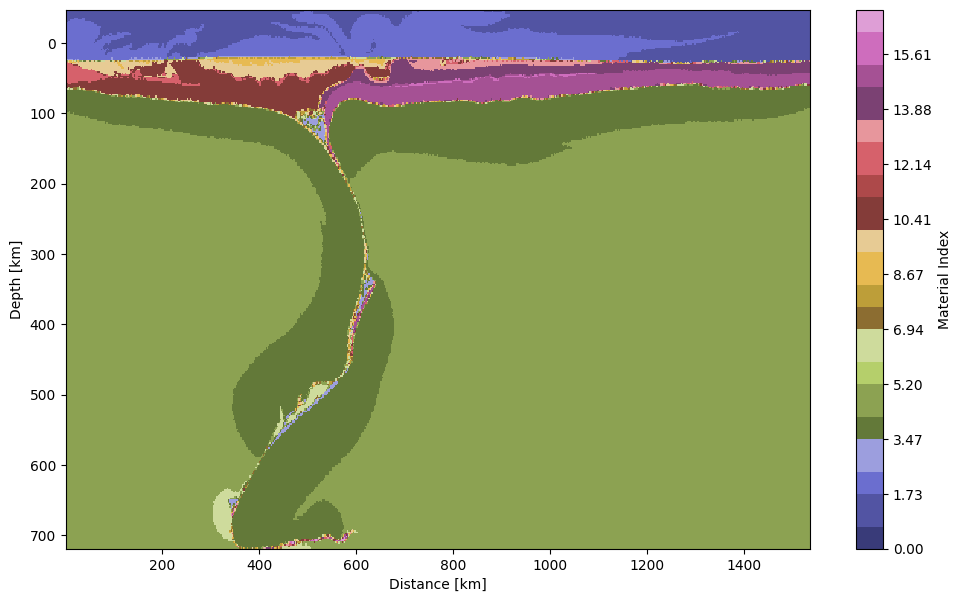

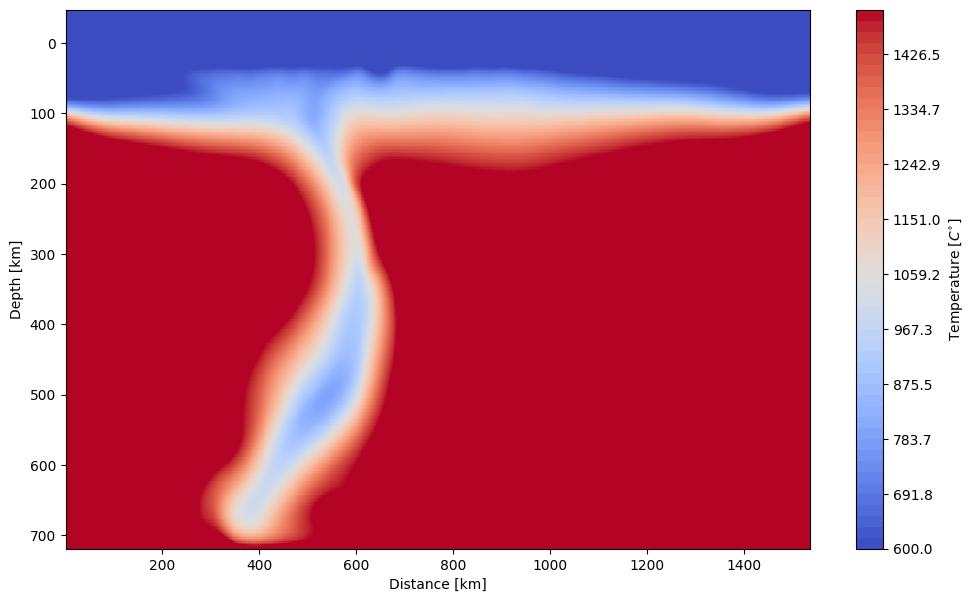

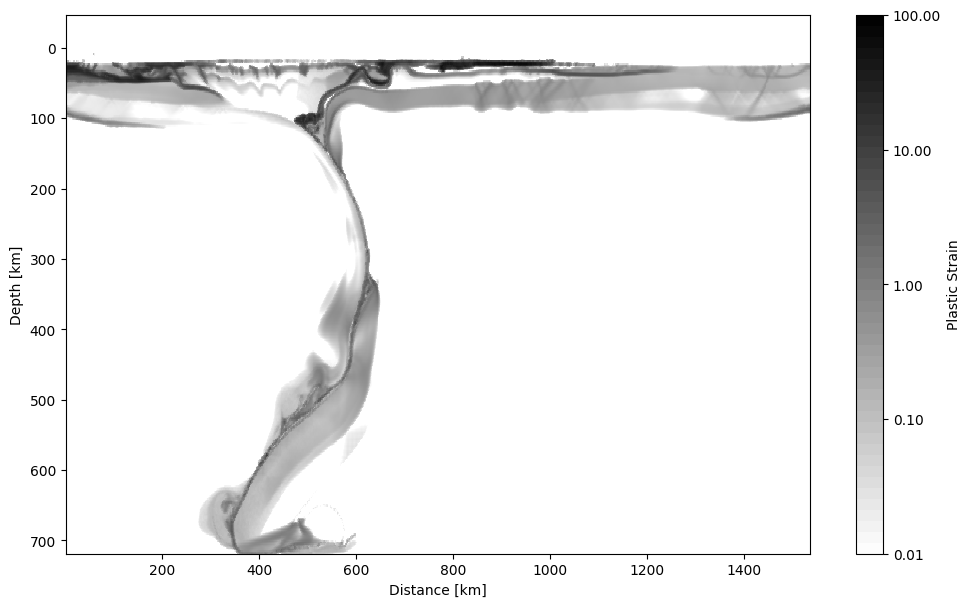

In [8]:
plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = material_array,cblimit_up = len(material_names), cblimit_down = 0,
                         log_bool=False, cb_name = 'tab20b',label = 'material.png', cbar_label = 'Material Index',plot_save = False)
plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = temp_array, cblimit_up = 1500, cblimit_down = 600,
                         log_bool=False, cb_name = 'coolwarm', label = 'temperature.png',cbar_label = r'Temperature [$C^{\circ}$]', plot_save = False)
plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = pstrain_array,cblimit_up = 1e2, cblimit_down = 1e-2, log_bool=True,
                         cb_name = 'binary', cbar_label = 'Plastic Strain',plot_save = False)


In [9]:
p_obj = pide.pide()

#DEFINING THE OBJECTS with p_obj.material
Eclogite_Object = Material(name = 'Eclogite_Object', material_index = 3, calculation_type = 'mineral', composition = {'garnet':0.6,'cpx':0.4}, interconnectivities = {'garnet':1, 'cpx':1.5}, 
el_cond_selections = {'garnet':17,'cpx':0}, water = {'garnet':50,'cpx':0}, xfe = {'garnet':0.2, 'cpx':0.5}, solid_phase_mixing_idx = 0, deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Eclogite_Object_2 = Material(name = 'Eclogite_Object', material_index = 3, calculation_type = 'mineral', composition = {'garnet':0.57,'cpx':0.38, 'sulphide':0.05}, interconnectivities = {'garnet':1, 'cpx':1.5,'sulphide':1.0}, 
el_cond_selections = {'garnet':17,'cpx':0,'sulphide':0}, water = {'garnet':50,'cpx':200}, xfe = {'garnet':0.2, 'cpx':0.5}, solid_phase_mixing_idx = 0,deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Lithospheric_Mantle_Object = Material(name = 'Lithospheric_Mantle_Object', material_index = 4, calculation_type = 'mineral', composition = {'ol':0.65,'opx':0.25,'garnet':0.05,'cpx':0.05},
interconnectivities = {'ol':1,'opx':2,'garnet':5, 'cpx':5}, 
el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0}, water_distr = True, water = {'bulk':100}, xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1}, solid_phase_mixing_idx = 0,deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Lithospheric_Mantle_Object_2 = Material(name = 'Lithospheric_Mantle_Object', material_index = 4, calculation_type = 'mineral', composition = {'ol':0.62,'opx':0.24,'garnet':0.045,'cpx':0.045,'sulphide':0.05},
interconnectivities = {'ol':1,'opx':2,'garnet':5, 'cpx':5,'sulphide':1}, 
el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0,'sulphide':0}, water_distr = True, water = {'bulk':100}, xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Asthenospheric_Mantle_Object = Material(name = 'Asthenospheric_Mantle_Object', material_index = 5,calculation_type = 'mineral', composition = {'ol':0.65,'opx':0.25,'garnet':0.05,'cpx':0.05},
interconnectivities = {'ol':1,'opx':2,'garnet':5, 'cpx':5}, 
el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0}, water_distr = True, water = {'bulk':100}, xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1}, solid_phase_mixing_idx = 0,deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Asthenospheric_Mantle_Object_2 = Material(name = 'Asthenospheric_Mantle_Object', material_index = 5,calculation_type = 'mineral', composition = {'ol':0.65,'opx':0.25,'garnet':0.05,'cpx':0.05},
interconnectivities = {'ol':1,'opx':2,'garnet':5, 'cpx':5}, 
el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0}, water_distr = True, water = {'bulk':300}, xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Mantle_Wedge_Object = Material(name = 'Mantle_Wedge_Object', material_index = 6, calculation_type = 'mineral', composition = {'ol':0.65,'opx':0.25,'garnet':0.05,'cpx':0.05},
interconnectivities = {'ol':1,'opx':2,'garnet':5, 'cpx':5}, 
el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0}, water = {'bulk':500}, water_distr = True, xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Mantle_Wedge_Object_2 = Material(name = 'Mantle_Wedge_Object', material_index = 6, calculation_type = 'mineral', composition = {'ol':0.62,'opx':0.24,'garnet':0.045,'cpx':0.045,'sulphide':0.05},
interconnectivities = {'ol':1,'opx':2,'garnet':5, 'cpx':5,'sulphide':1}, 
el_cond_selections = {'ol':4, 'opx':0, 'garnet':0,'cpx':0,'sulphide':0}, water = {'bulk':1000}, water_distr = True, xfe = {'ol':0.1,'opx':0.1,'garnet':0.1, 'cpx':0.1}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Oceanic_Sediment = Material(name = 'Oceanic_Sediment',material_index = 7, calculation_type = 'value', resistivity_medium = 200.0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Oceanic_Sediment_2 = Material(name = 'Oceanic_Sediment',material_index = 7, calculation_type = 'value', resistivity_medium = 50.0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Oceanic_Upper_Crust = Material(name = 'Oceanic_Upper_Crust',material_index = 8, calculation_type = 'mineral', composition = {'cpx':0.6, 'plag':0.4},
water = {'cpx':0, 'plag':0}, interconnectivities = {'cpx': 1,'plag':1.5}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Oceanic_Upper_Crust_2 = Material(name = 'Oceanic_Upper_Crust',material_index = 8, calculation_type = 'mineral', composition = {'cpx':0.575, 'plag':0.375, 'sulphide': 0.05},
water = {'cpx':0, 'plag':0}, interconnectivities = {'cpx': 1,'plag':1.5,'sulphide':1}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Sediments_UP_Object = Material(name = 'Continental_Sediments_UP_Object',material_index = 9, calculation_type = 'value', resistivity_medium = 200.0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Sediments_UP_Object_2 = Material(name = 'Continental_Sediments_UP_Object',material_index = 9, calculation_type = 'value', resistivity_medium = 0.01,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Upper_Crust_UP_Object = Material(name = 'Continental_Upper_Crust_UP_Object',material_index = 10, calculation_type = 'rock', composition = {'granite':1.0},interconnectivities = {'granite':1},
el_cond_selections = {'granite':0}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Upper_Crust_UP_Object_2 = Material(name = 'Continental_Upper_Crust_UP_Object',material_index = 10, calculation_type = 'rock', composition = {'granite':0.95, 'other_rock':0.05},
interconnectivities = {'granite':1,'other_rock':1},
el_cond_selections = {'granite':0,'other_rock':3}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})
#other rock 3 is graphite

Continental_Lower_Crust_UP_Object = Material(name = 'Continental_Lower_Crust_UP_Object',material_index = 11, calculation_type = 'rock', composition = {'granulite':1.0},interconnectivities = {'granulite':1},
el_cond_selections = {'granulite':0}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Lower_Crust_UP_Object_2 = Material(name = 'Continental_Lower_Crust_UP_Object',material_index = 11, calculation_type = 'rock', composition = {'granulite':0.95, 'other_rock':0.05},
interconnectivities = {'granulite':1, 'other_rock':1},
el_cond_selections = {'granulite':0,'other_rock':3}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Decollement_LP = Material(name = 'Decollement_LP',material_index = 12, calculation_type = 'value', resistivity_medium = 300.0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Decollement_LP_2 = Material(name = 'Decollement_LP',material_index = 12, calculation_type = 'value', resistivity_medium = 0.01,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Sediments_LP_Object = Material(name = 'Continental_Sediments_LP_Object', material_index = 13,calculation_type = 'value', resistivity_medium = 100.0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Sediments_LP_Object_2 = Material(name = 'Continental_Sediments_LP_Object', material_index = 13,calculation_type = 'value', resistivity_medium = 1e-2,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Upper_Crust_LP_Object = Material(name = 'Continental_Upper_Crust_LP_Object', material_index = 14,calculation_type = 'rock', composition = {'granite':1.0},interconnectivities = {'granite':1},
el_cond_selections = {'granite':0}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Upper_Crust_LP_Object_2 = Material(name = 'Continental_Upper_Crust_LP_Object',material_index = 14, calculation_type = 'rock', composition = {'granite':0.95, 'other_rock':0.05},
interconnectivities = {'granite':1,'other_rock':1},
el_cond_selections = {'granite':0,'other_rock':3}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Lower_Crust_LP_Object = Material(name = 'Continental_Lower_Crust_LP_Object', material_index = 15,calculation_type = 'rock', composition = {'granulite':1.0},interconnectivities = {'granulite':1},
el_cond_selections = {'granulite':0}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Continental_Lower_Crust_LP_Object_2 = Material(name = 'Continental_Lower_Crust_LP_Object',material_index = 15, calculation_type = 'rock', composition = {'granulite':0.95, 'other_rock':0.05},
interconnectivities = {'granulite':1, 'other_rock':1},
el_cond_selections = {'granulite':0,'other_rock':3}, solid_phase_mixing_idx = 0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

#NotSure 
Decollement_UP = Material(name = 'Decollement_UP',material_index = 16, calculation_type = 'value', resistivity_medium = 100.0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})
Decollement_UP_2 = Material(name = 'Decollement_UP',material_index = 16, calculation_type = 'value', resistivity_medium = 1e-2,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})

Fault = Material(name = 'Fault', material_index = 17, calculation_type = 'value', resistivity_medium = 100.0,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})
Fault_2 = Material(name = 'Fault', material_index = 17, calculation_type = 'value', resistivity_medium = 1e-2,
deformation_dict = {'function_method':'exponential',
'conductivity_decay_factor':0.2, 'strain_decay_factor':0.2,'strain_percolation_threshold':None})


In [10]:
#creating material_object_list:
material_object_list = [Eclogite_Object,Lithospheric_Mantle_Object,Asthenospheric_Mantle_Object,Mantle_Wedge_Object,Oceanic_Sediment,Oceanic_Upper_Crust, Continental_Sediments_UP_Object,
Continental_Upper_Crust_UP_Object,Continental_Lower_Crust_UP_Object,Decollement_LP,Continental_Sediments_LP_Object,Continental_Upper_Crust_LP_Object,
Continental_Lower_Crust_LP_Object,Decollement_UP,Fault]

material_object_list_2 = [Eclogite_Object_2,Lithospheric_Mantle_Object_2,Asthenospheric_Mantle_Object_2,Mantle_Wedge_Object_2,Oceanic_Sediment_2,Oceanic_Upper_Crust_2, Continental_Sediments_UP_Object_2,
 Continental_Upper_Crust_UP_Object_2,Continental_Lower_Crust_UP_Object_2,Decollement_LP_2,Continental_Sediments_LP_Object_2,Continental_Upper_Crust_LP_Object_2,
 Continental_Lower_Crust_LP_Object_2,Decollement_UP_2,Fault_2]

material_skip_list = [None,5,50,None,None,None,None,None,None,None,None,None,None,None,None]

In [12]:
#creating model_object
mt_model_object = Model(material_list = material_object_list, material_array = material_array, material_list_2 = material_object_list_2, T = temp_array, P = pressure_array, model_type = 'underworld_2d', melt = melt_array,
p_strain = pstrain_array, material_node_skip_rate_list = material_skip_list)
backgr_cond = mt_model_object.calculate_conductivity(type = 'background', num_cpu = 5)

Initiating calculation for the materials appended to the model.
##############################################################
The conductivity for the material  Eclogite_Object  is calculated.
The conductivity for the material  Lithospheric_Mantle_Object  is calculated.
The conductivity for the material  Asthenospheric_Mantle_Object  is calculated.
The conductivity for the material  Mantle_Wedge_Object  is calculated.
The conductivity for the material  Oceanic_Sediment  is calculated.
The conductivity for the material  Oceanic_Upper_Crust  is calculated.
The conductivity for the material  Continental_Sediments_UP_Object  is calculated.
The conductivity for the material  Continental_Upper_Crust_UP_Object  is calculated.
The conductivity for the material  Continental_Lower_Crust_UP_Object  is calculated.
The conductivity for the material  Decollement_LP  is calculated.
The conductivity for the material  Continental_Sediments_LP_Object  is calculated.
The conductivity for the material  C

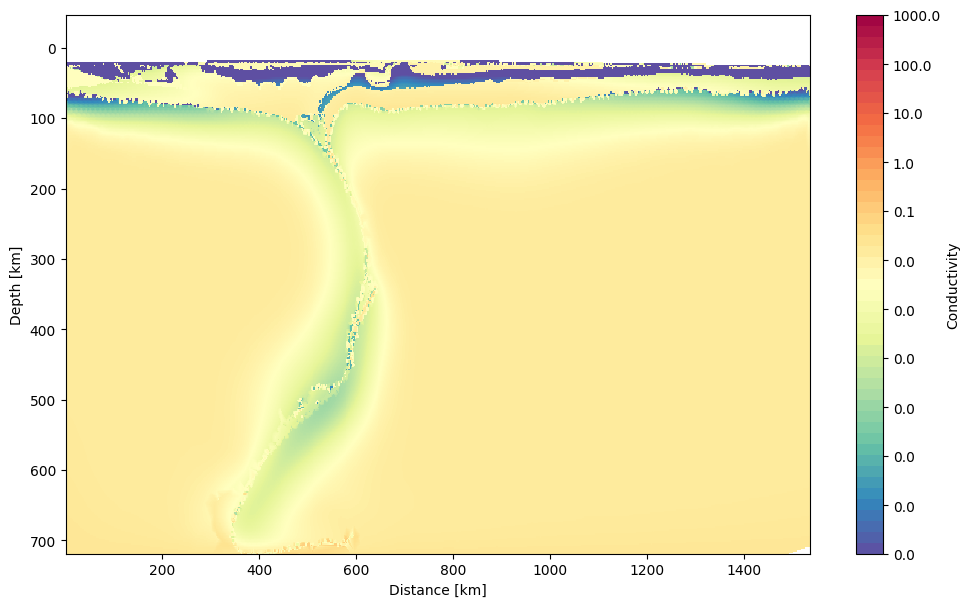

In [13]:
plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = backgr_cond,cblimit_up = 1e3,
cblimit_down = 1e-8, log_bool=True, cb_name = 'Spectral_r',cbar_label = 'Conductivity [S/m]',plot_save = False)

Initiating calculation for the materials appended to the model.
##############################################################
The conductivity for the material  Eclogite_Object  is calculated.
The conductivity for the material  Lithospheric_Mantle_Object  is calculated.
The conductivity for the material  Asthenospheric_Mantle_Object  is calculated.
The conductivity for the material  Mantle_Wedge_Object  is calculated.
The conductivity for the material  Oceanic_Sediment  is calculated.
The conductivity for the material  Oceanic_Upper_Crust  is calculated.
The conductivity for the material  Continental_Sediments_UP_Object  is calculated.
The conductivity for the material  Continental_Upper_Crust_UP_Object  is calculated.
The conductivity for the material  Continental_Lower_Crust_UP_Object  is calculated.
The conductivity for the material  Decollement_LP  is calculated.
The conductivity for the material  Continental_Sediments_LP_Object  is calculated.
The conductivity for the material  C

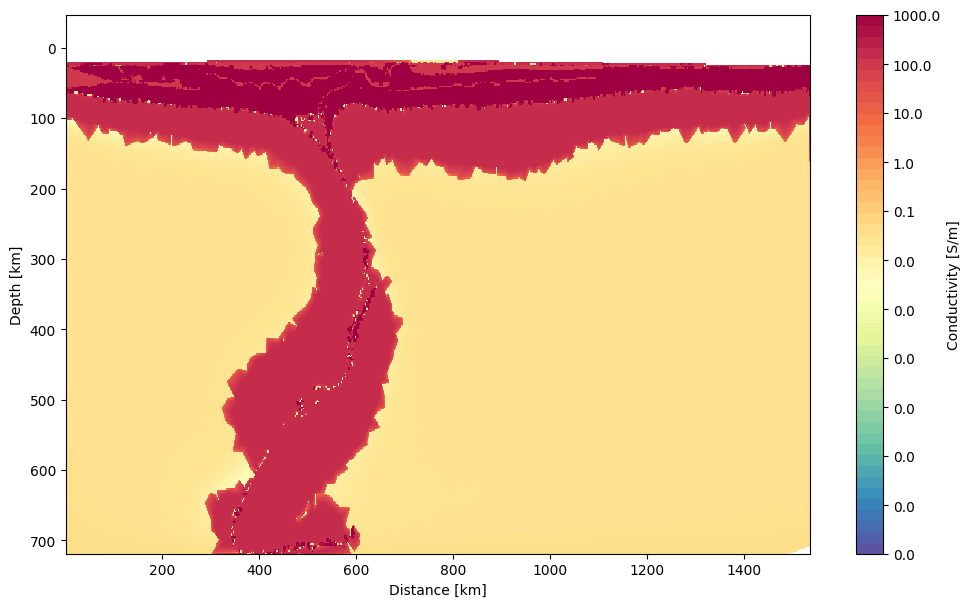

In [14]:
max_cond = mt_model_object.calculate_conductivity(type = 'maximum', num_cpu = 6)

plot_2D_underworld_Field(xmesh = x_mesh_centers, ymesh = y_mesh_centers, Field = max_cond,cblimit_up = 1e3,
cblimit_down = 1e-8, log_bool=True, cb_name = 'Spectral_r',cbar_label = 'Conductivity [S/m]',plot_save = False)

In [16]:
deform_cond, strain_decay, cond_decay, misfit = mt_model_object.calculate_deformation_related_conductivity(method = 'plastic_strain', function_method = 'exponential', 
low_deformation_threshold = 1e-2, high_deformation_threshold = 1e2, num_cpu = 6)

IndexError: tuple index out of range